
#### 这个版本交换 crop和muscle的次序.
原因:不删除是为了有更多眼电的数据可以用来ICA
删除是因为你发现大多数区域直接就被标红了,不能提供眼电的信息,反而扭曲了.

muscle标注不是那么智能,会重复标注bad区域..所以blank干脆 crop掉 而不仅仅是标注.

crop有两次
一次是把三个程序分别crop出来
二次是把block之间的blanck区间crop出来

其实cropblank可以在一开始的rename做. 但是blank区间也不好标注,因为ASSR的不一样.
需要专门写一个脚本来完成数据的切割?



In [1]:
%matplotlib qt

In [2]:
import os.path as op
# from memory_profiler import memory_usage
import mne
from mne.preprocessing import ICA
from mne.preprocessing import annotate_muscle_zscore
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np

In [7]:
sub_ids = [
            'pre4028_y'
           ]
data_path = '.\data\\1raw_rename\\'

'''

https://mne.discourse.group/t/where-i-can-find-a-montage-for-neuroscan-64ch/4179/3

'''
sub_id = sub_ids[0]
fname = op.join(data_path + sub_id + '.fif')
raw = mne.io.read_raw_fif(fname, preload=True, verbose=None)
# 检查一下有没有数据基本问题:是否标注了坏导,是否有不对的mark,都给去掉
raw.plot(n_channels = 50, duration =40, scalings=60e-6, remove_dc = True,)


Opening raw data file .\data\1raw_rename\pre4028_y.fif...


C:\Users\SilverBullet\AppData\Local\Temp\ipykernel_27720\2627345903.py:13: RuntimeWarning: This filename (.\data\1raw_rename\pre4028_y.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fname, preload=True, verbose=None)


    Range : 0 ... 4891799 =      0.000 ...  4891.799 secs
Ready.
Reading 0 ... 4891799  =      0.000 ...  4891.799 secs...


In [8]:
raw.drop_channels(['CB1','CB2', 'Trigger','EKG', 'EMG']) # i dont need those channels
rename_dict = {'HEO': 'HEOG','VEO':'VEOG','FP1':'Fp1', 'FPZ':'Fpz', 'FP2':'Fp2', 'FZ':'Fz', 'FCZ':'FCz', 'CZ':'Cz', 'CPZ':"CPz", 'PZ':"Pz", 'POZ':"POz", 'OZ':"Oz"}
raw.rename_channels(rename_dict)
chan_types_dict = { "VEOG":"eog","HEOG":"eog"}
raw.set_channel_types(chan_types_dict)
#电极点位置确定
# raw.plot_sensors() # 画出电极位置
locs_info_path = './standard-10-5-cap385.elp'
# montage = mne.channels.read_custom_montage(locs_info_path, head_size=0.095)
montage = mne.channels.make_standard_montage(kind='standard_1005')
# 自带的montage,如果没有montage文件. 如果没有就用mne自带的
# mne.channels.get_builtin_montages()
raw.set_montage(montage)
# raw.plot_sensors()# 对比一下 montage之后的位置
plt.show() # 只呈现一次

|### crop 裁剪一个实验的数据出来

In [9]:
'''

crop

自动化截取RSA部分的数据

找到RSA实验的最前和最后的marker,截止时间

截取RSA的RAW数据
'''
# 读取和打印marker
# events, event_id = mne.events_from_annotations(raw)
# for marker_name in event_id:
#     print(marker_name)

# 确定RSA的marker
list_RSAmarker = ['101', '102', '103', '104', '111', '112', '113', '114', '121', '122', '123', '124', '131', '132', '133', '134', ]

# 提取原始数据中的所有事件
events, event_id = mne.events_from_annotations(raw)

# 通过遍历list_RSAmarker列表，获取所需事件的索引
selected_event_indices = [event_id[str(marker)] for marker in list_RSAmarker]

# 提取与list_RSAmarker中的标记对应的事件
selected_events = np.array([event for event in events if event[2] in selected_event_indices])

# 找到最早和最晚出现的onset time
first_onset_time = raw.times[selected_events[0, 0]]-2 #第一个marker的时间再往前2s
# 给出2的trail空间
last_onset_time = raw.times[selected_events[-1, 0]]+2 #最后一个marker的时间再往后2s

print(f"First onset time: {first_onset_time} s")
print(f"Last onset time: {last_onset_time} s")

raw_crop  = raw.copy().crop(tmin=first_onset_time, tmax=last_onset_time)
# 画出来的时间和数据的时间并不一样了.
raw_crop.plot(n_channels = 50, duration =40, scalings=60e-6, start=raw_crop.annotations.onset[0])


Used Annotations descriptions: ['1', '101', '102', '103', '104', '111', '112', '113', '114', '121', '122', '123', '124', '13', '131', '132', '133', '134', '14', '177', '193', '200', '201', '21', '210', '211', '22', '255', '29', '30', '37', '4', '41', '5', '6']
First onset time: 0.265 s
Last onset time: 1899.364 s


### crop2 直接把block interval的部分给删除掉.

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, reject_by_annotation=True, preload=True)
并不存在函数 reject_by_annotation

所以还是的读出来

In [10]:
'''
标注出block interval区间.
'''
raw_cropBlanck = raw_crop.copy()
# annots_break是从0开始算,不会自动根据raw.first_time调整的.
annots_break = mne.preprocessing.annotate_break(raw_cropBlanck,min_break_duration=20,)
# 这里的annotations是根据first_time调整过的.需要调整回来,和annots_break一样不调整,因为后面set_annotations会自动调整一次.
annots_cropBlanck = raw_cropBlanck.annotations
if annots_cropBlanck.orig_time is not None:
    # 12 13 14 15往后不知道为何没有进行矫正.你发现他们的 orig_time 不等于none
    annots_cropBlanck.onset = annots_cropBlanck.onset
else:
    # 等于none的时候,就是没有进行矫正的时候.需要手动矫正
    annots_cropBlanck.onset = annots_cropBlanck.onset - raw_cropBlanck.first_time

# 两个没有调整过的annotation相加
annotations_crop2break=annots_cropBlanck + annots_break
raw_cropBlanck.set_annotations(annotations=annotations_crop2break)
raw_cropBlanck.plot(n_channels = 50, duration =40, scalings=60e-6)

Ignoring annotations with descriptions starting with: bad, edge

Detected 2 break periods of >= 20 s duration:
    567.5 – 645.1 s [77.6 s]
    1238.6 – 1311.6 s [72.9 s]
In total, 7.9% of the data (150.6 s) have been marked as a break.



In [11]:
'''

把RSA数据的block interval部分给删除掉.
因为 preprocessing检测muscle的时候,会把block interval的部分也检测出来.这导致后面进行Z分数的时候不准.

这会影响到后面muscle的参数设置.

说白了,就是能让检测muscle的时候,更加敏感准确.

'''
# 假设 annots_break 是包含 bad_break 的开始时间和持续时间的注释对象
# 获取 bad_break 的开始和结束时间
# 这里和前面反过来,因为crop是不看orig_time的,所以自动矫正的反而有问题.
if annots_break.orig_time is None:
    # 没有自动矫正,那就保持不变
    onsets = annots_break.onset
else:
    # 矫正过的,就恢复回去
    onsets = annots_break.onset - raw_cropBlanck.first_time

durations = annots_break.duration
ends = onsets + durations

# 初始化一个新的 Raw 对象，用于存储截取后的数据
raw_crop2 = None
# 遍历原始数据，跳过 bad_break 区间并将其他部分添加到新的 Raw 对象中
start = 0
for bad_start, bad_end in zip(onsets, ends):
    raw_temp = raw_cropBlanck.copy().crop(tmin=start, tmax=bad_start)
    if raw_crop2 is None:
        raw_crop2 = raw_temp
    else:
        raw_crop2.append(raw_temp)
    start = bad_end
# 添加原始数据中最后一个 bad_break 区间之后的部分
raw_temp = raw_cropBlanck.copy().crop(start, None)
raw_crop2.append(raw_temp)
raw_crop2.plot(n_channels = 50, duration =40, scalings=60e-6, remove_dc = True,)

In [13]:

'''
找坏导本质上也就是观察一下前面一段区间有没有很明显有问题的channel
这个其实可以做多次,
问题:是否应该放在muscle之前?
理论上来说muscle评分应该不会是依据少数几个channel来进行的.

答曰:经过检验,确实会因为一个channel标红整个区间的情况.

所以在进行muscle score之前,插值一次坏导.
'''
#找出坏导
raw_bad = raw_crop2.copy()
# raw.plot(n_channels = 50, duration =40, scalings=60e-6, remove_dc = True,
#                  highpass=0.1, lowpass=30)
raw_bad.plot(n_channels=50, duration=40, scalings=60e-6, remove_dc=True, )

In [14]:
#插值
# original_bads = deepcopy(raw_bad.info['bads'])
print(raw_bad.info['bads'])
#截取一部分作图
# raw.copy().crop(tmin=0,tmax=100).plot(n_channels = 50, duration =40, scalings=40e-6,remove_dc = True,highpass=1,lowpass=40)
# How interpolation works¶根据手册，是根据topo位置来插值？所以需要location
raw_interp = raw_bad.copy().interpolate_bads(reset_bads=True)
print(raw_interp.info['bads'])
# raw_interp.copy().crop(tmin=0,tmax=100).plot(n_channels = 50, duration =40, scalings=40e-6, remove_dc = True,highpass=1,lowpass=40)
# 不想改后面代码的变量名了.
raw_crop2 = raw_interp

['F7', 'F8', 'Fp1', 'AF4', 'Fpz', 'Fp2']
Interpolating bad channels
    Automatic origin fit: head of radius 96.7 mm
Computing interpolation matrix from 56 sensor positions
Interpolating 6 sensors
[]


In [15]:
'''
在进行filter之前,查找muscle,可以先把工频给删除掉.
之所以要在filter之前,是因为muscle算法的判断就是高频的震荡(比如移动身体导致的皮肤和电极的摩擦)
'''
raw_muscle = raw_crop2.copy()
raw_muscle.notch_filter([50, 100, 150, 200])
threshold_muscle = 5  # z-score  设置得稍微小一点,选出更多的范围.不过这样子可能导致bad区间里面也有眼电成分.如果有一半标红了,那就没意义了..autoreject对眼电没辙.
# Choose one channel type, if there are axial gradiometers and magnetometers,
# select magnetometers as they are more sensitive to muscle activity.
# min_length_good=0.1 两个bad之间如果很短,就之间标为bad范围. 两个小的化为一个大的
# filter_freq=[100, 150] 频率再设置宽一点.
annot_muscle, scores_muscle = annotate_muscle_zscore(
    raw_muscle, ch_type="eeg", threshold=threshold_muscle, min_length_good=2,
    filter_freq=[110, 140],n_jobs=6) # 选择区间是110-140HZ,这个已经远超神经信号的频率了
# muscle的marker加上原来的marker
aonnots_raw_muscle = raw_muscle.annotations
if aonnots_raw_muscle.orig_time is not None:
    # 没有自动矫正,那就保持不变
    aonnots_raw_muscle.onset = aonnots_raw_muscle.onset
else:
    # 矫正过的,就恢复回去
    aonnots_raw_muscle.onset = aonnots_raw_muscle.onset - raw_muscle.first_time

raw_muscle.set_annotations(annot_muscle+aonnots_raw_muscle)
raw_muscle.plot(n_channels = 50, duration =40, scalings=60e-6, remove_dc = True,
                 highpass=0.1, lowpass=30)
'''
查看 muscle score 的分布情况 在时间线上.
'''
fig, ax = plt.subplots()
ax.plot(raw_muscle.times, scores_muscle)
ax.axhline(y=threshold_muscle, color='r')
ax.set(xlabel='time, (s)', ylabel='zscore', title='Muscle activity')

Filtering raw data in 3 contiguous segments
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:    1.6s finished


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 1.1e+02 - 1.4e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 110.00
- Lower transition bandwidth: 27.50 Hz (-6 dB cutoff frequency: 96.25 Hz)
- Upper passband edge: 140.00 Hz
- Upper transition bandwidth: 35.00 Hz (-6 dB cutoff frequency: 157.50 Hz)
- Filter length: 121 samples (0.121 s)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=6)]: Done  57 out of  62 | elapsed:    2.0s remaining:    0.1s
[Parallel(n_jobs=6)]: Done  62 out of  62 | elapsed:    2.1s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:    3.0s
[Parallel(n_jobs=6)]: Done  62 out of  62 | elapsed:   11.2s finished


Setting 2 of 1748518 (0.00%) samples to NaN, retaining 1748516 (100.00%) samples.
Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Setting up band-pass filter from 0.1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 30.00 Hz: -6.02, -6.02 dB



[Text(0.5, 0, 'time, (s)'),
 Text(0, 0.5, 'zscore'),
 Text(0.5, 1.0, 'Muscle activity')]

In [16]:
'''
滤波放在muscle之后,因为muscle的判断是根据高频的震荡来判断的.
翻译上面这句话
'''
#滤波
# raw_interp.copy().plot_psd(area_mode='range', average=False)
# 要做时频分析，上限高一点？脑干 80
# 不同数据对这个要求不一样,这里稍微设置高一点,后面再各自处理好了.
raw_middlepass = raw_muscle.copy().filter(0.1, 40.)
sample_rate=500
freqs = np.arange(50, sample_rate / 2, 50)
raw_middlepass_notch = raw_middlepass.copy().notch_filter(freqs=freqs)
# raw_middlepass_notch.copy().plot_psd(area_mode='range', average=False)
#重参考
raw_rerefer = raw_middlepass_notch.copy().set_eeg_reference(ref_channels='average')
#保存,在ICA之前
raw_rerefer.plot(n_channels = 50, duration =40, scalings=60e-6, remove_dc = True,)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:    3.1s finished


Filtering raw data in 3 contiguous segments
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:    1.6s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


In [17]:
# 根据amplitude标注一次 然后手动去调整宽度.
'''
注意 amplitude标注并不是标注出所有的bad区间,其原理是根据 幅值增长速度 而非 幅度本身

因此其作用应该是标注出幅值快速变化的时间点,你要去画出来之后,在EEG的图上,留下这些bad marker,自己人为地去扩宽一下.

'''
# peak的选择可以严格一点.理论上来说眼电的幅值也就20uV
# amp_annots = mne.preprocessing.annotate_amplitude(raw_rerefer, peak=1e-5, min_duration=0.05)[0]
# # 在原有基础上加上amp_annots
# if raw_rerefer.annotations.orig_time is None:
#     raw_rerefer.annotations.onset = raw_rerefer.annotations.onset - raw_rerefer.first_time
#
# raw_rerefer.annotations.onset = raw_rerefer.annotations.onset
# raw_rerefer.set_annotations(raw_rerefer.annotations+amp_annots)
# raw_rerefer.plot(n_channels = 50, duration =40, scalings=60e-6)

'\n注意 amplitude标注并不是标注出所有的bad区间,其原理是根据 幅值增长速度 而非 幅度本身\n\n因此其作用应该是标注出幅值快速变化的时间点,你要去画出来之后,在EEG的图上,留下这些bad marker,自己人为地去扩宽一下.\n\n'

In [18]:
'''
问题，不知道ICA到底有没有吧 break计算上。
'''
import time
time_start=time.time()
# ICA
raw_filt = raw_rerefer.copy()
# raw_filt.load_data().filter(l_freq=0.1, h_freq= 40)
raw_filt.plot(n_channels = 50, duration =40, scalings=60e-6)
ica = ICA(n_components=40, random_state=97, )
#训练，但是并没有删除
ica.fit(raw_filt)
#计时
time_end=time.time()
print('time cost',time_end-time_start,'s')
print(sub_id)

Fitting ICA to data using 62 channels (please be patient, this may take a while)
Omitting 138422 of 1748518 (7.92%) samples, retaining 1610096 (92.08%) samples.
Selecting by number: 40 components
Fitting ICA took 188.1s.
time cost 194.0037603378296 s
pre4028_y


Using EOG channels: HEOG, VEOG
Omitting 138422 of 1748518 (7.92%) samples, retaining 1610096 (92.08%) samples.
Omitting 138422 of 1748518 (7.92%) samples, retaining 1610096 (92.08%) samples.
Omitting 138422 of 1748518 (7.92%) samples, retaining 1610096 (92.08%) samples.
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Omitting 138422 of 1748518 (7.92%) samples, retaining 1610096 (92.08%) samples.
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


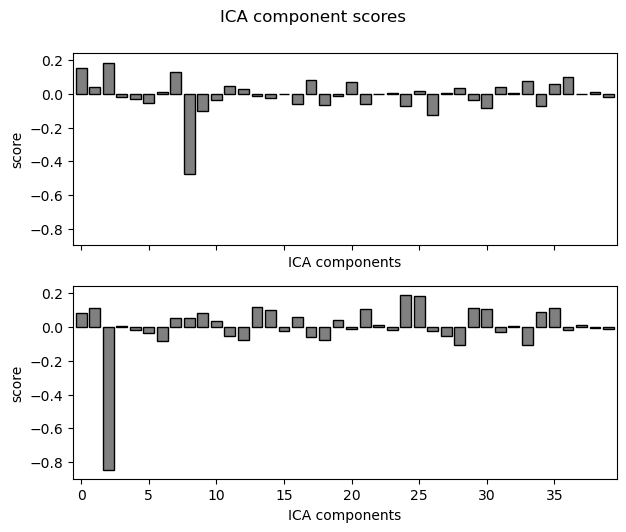

In [19]:
#有多种选择，自动，手动。找出eog component
# eog_inds, eog_scores = ica.find_bads_eog(raw_filt, threshold=3.0, ch_name='Fp2')#0 7数据眼电有问题
eog_inds, eog_scores = ica.find_bads_eog(raw_filt, threshold='auto') # 用3是因为并不是真的那么准确,你需要人为判断.如果改成2,,可能会自动排除许多component.
#参考一下机器
ica.plot_scores(eog_scores)

In [ ]:
#但是要自己检查一下,有问题就手动修改eog_ins
%matplotlib qt
ica.plot_components(inst=raw_filt, show=True)

In [ ]:
import torch

In [ ]:
from mne_icalabel import label_components
import mne_icalabel
# assuming you have a Raw and ICA instance previously fittedpip
gui = label_components(raw_filt, ica, method='iclabel')
print(ica.labels_)


In [20]:
'''
上面是找眼电成分,这里再找一次muscle成分.

你会发现muscle渗透到了很多成分当中.甚至超过一半,但是你这部分的脚本仅仅是挑出来眼电.
即把眼电逼出来,尽量避免混合 眼电+muscle

'''
muscle_idx_auto, scores = ica.find_bads_muscle(raw_filt)
ica.plot_scores(scores, exclude=muscle_idx_auto)
print(f'Automatically found muscle artifact ICA components: {muscle_idx_auto}')

Setting 27746 of 567454 (4.89%) samples to NaN, retaining 539708 (95.11%) samples.
Effective window size : 2.048 (s)
Automatically found muscle artifact ICA components: [1, 7, 18, 29]


In [22]:
# 手动 或者 用手点.
eog_inds = [2,8]

In [23]:
#eog_inds = [0,1]
ica.exclude = eog_inds
ica.plot_scores(eog_scores)
#这个……在filt_raw训练出来的model，可以直接给别的数据用。。
reconst_raw =raw_filt.copy()
reconst_raw.plot(n_channels = 50, duration =40, scalings=40e-6)
ica.apply(reconst_raw)
reconst_raw.plot(n_channels = 50, duration =40, scalings=40e-6)

Applying ICA to Raw instance
    Transforming to ICA space (40 components)
    Zeroing out 2 ICA components
    Projecting back using 62 PCA components


In [25]:
#确认无误，保存一下,raw ica
save_path_ica = '.\data\\4raw_ica\\'
ica.save(save_path_ica + sub_id + 'RSA.fiff', overwrite=True)
reconst_raw.save(save_path_ica + sub_id + 'RSA.fif', overwrite=True)

Overwriting existing file.
Writing ICA solution to E:\实验\阅读困难\数据处理\pre4\data\4raw_ica\pre4028_yRSA.fiff...
Overwriting existing file.
Writing E:\实验\阅读困难\数据处理\pre4\data\4raw_ica\pre4028_yRSA.fif


C:\Users\SilverBullet\AppData\Local\Temp\ipykernel_27720\3880872152.py:3: RuntimeWarning: This filename (.\data\4raw_ica\pre4028_yRSA.fiff) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(save_path_ica + sub_id + 'RSA.fiff', overwrite=True)
C:\Users\SilverBullet\AppData\Local\Temp\ipykernel_27720\3880872152.py:4: RuntimeWarning: This filename (E:\实验\阅读困难\数据处理\pre4\data\4raw_ica\pre4028_yRSA.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  reconst_raw.save(save_path_ica + sub_id + 'RSA.fif', overwrite=True)


Closing E:\实验\阅读困难\数据处理\pre4\data\4raw_ica\pre4028_yRSA.fif
[done]


In [ ]:
'''
脑区域图。

'''
raw.plot_sensors(show_names=True)